In [1]:
import copy
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima, FakeSherbrooke, FakeLimaV2, FakeWashington
from qiskit import QuantumCircuit, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}
DD = {'output': 'mpl', 'fold': 50, 'idle_wires': False}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
real_backend = provider.get_backend('ibm_sherbrooke')
# real_backend = provider.get_backend('ibm_washington')

In [4]:
fake_backend = FakeSherbrooke() #FakeWashington() #FakeLima()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [36]:
import os
from tqdm.notebook import tqdm
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    Js = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)])
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                Js.append(entry['J'])
                # ideal_exp_vals.append(entry['ideal_exp_value'])
                # noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, Js #, ideal_exp_vals, noisy_exp_vals

train_circuits, Js = load_circuits('./data/ising_zne_hardware/10q_sherbrooke_sameJ_h0.66pi', '.pk')

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# train_circuits[61].remove_final_measurements()
train_circuits[2][0]#.draw(**D)

CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[ParameterExpression(1.5707963267949)]), qubits=(Qubit(QuantumRegister(127, 'q'), 113),), clbits=())

In [37]:
def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

In [38]:
# obs_list = ['I'*i+'Z'+'I'*(6-1-i) for i in range(6)]
# padded_obs = [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 6), 127)) for obs in obs_list]

obs_list = ['Z'+'I'*9, 'I'*2+'Z'+'I'*7, 'I'*4+'Z'+'I'*5, 'I'*6+'Z'+'I'*3, 'I'*9+'Z'+'I'*0]
padded_obs_all_circs = []
for trans_circuit in tqdm(train_circuits):
    padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 10), 127)) for obs in obs_list]

# obs_list = ['Z'+'I'*99, 'I'*19+'Z'+'I'*80, 'I'*29+'Z'+'I'*70, 'I'*39+'Z'+'I'*60, 'I'*49+'Z'+'I'*50]
# padded_obs_all_circs = []
# for trans_circuit in tqdm(train_circuits):
#     padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

  0%|          | 0/300 [00:00<?, ?it/s]

In [39]:
for i in range(150, 155):
    print(126-padded_obs_all_circs[i].paulis.to_labels()[0].find('Z'))

113
115
117
119
122


In [46]:
with open('./data/ising_zne_hardware/10q_sherbrooke_30persteps_shots1w_sameJ_h0.66pi_job_ids.pk', 'rb') as file:
    loaded = pickle.load(file)
loaded

['chtmjuhoq2qn3r23dsn0',
 'chtmjur91dmpcngprk00',
 'chtmk01vrup8981kk8ig',
 'chtmk0pvrup8981kk970',
 'chtmk1hvrup8981kk9s0',
 'chtmk2hvrup8981kkaf0',
 'chtmk4ai3durlgqvnvdg',
 'chtmk5pvrup8981kkc4g',
 'chtmk7391dmpcngprr30',
 'chtmk8bgsimdkulqub2g']

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
service = QiskitRuntimeService()

In [41]:
mitigated_vals = []
noisy_vals = []
for job_id in tqdm(loaded[:4]+loaded[5:]):
# for job_id in tqdm(loaded):
    ret_job_result = service.job(job_id).result()
    mitigated_values = ret_job_result.values
    for i in range(30):
        mitigated_vals.append(mitigated_values[i*5:(i+1)*5].tolist())
        noisy_vals.append([ret_job_result.metadata[j]['zne']['noise_amplification']['values'][0] for j in list(range(i*5,(i+1)*5))])

  0%|          | 0/9 [00:00<?, ?it/s]

# Verification

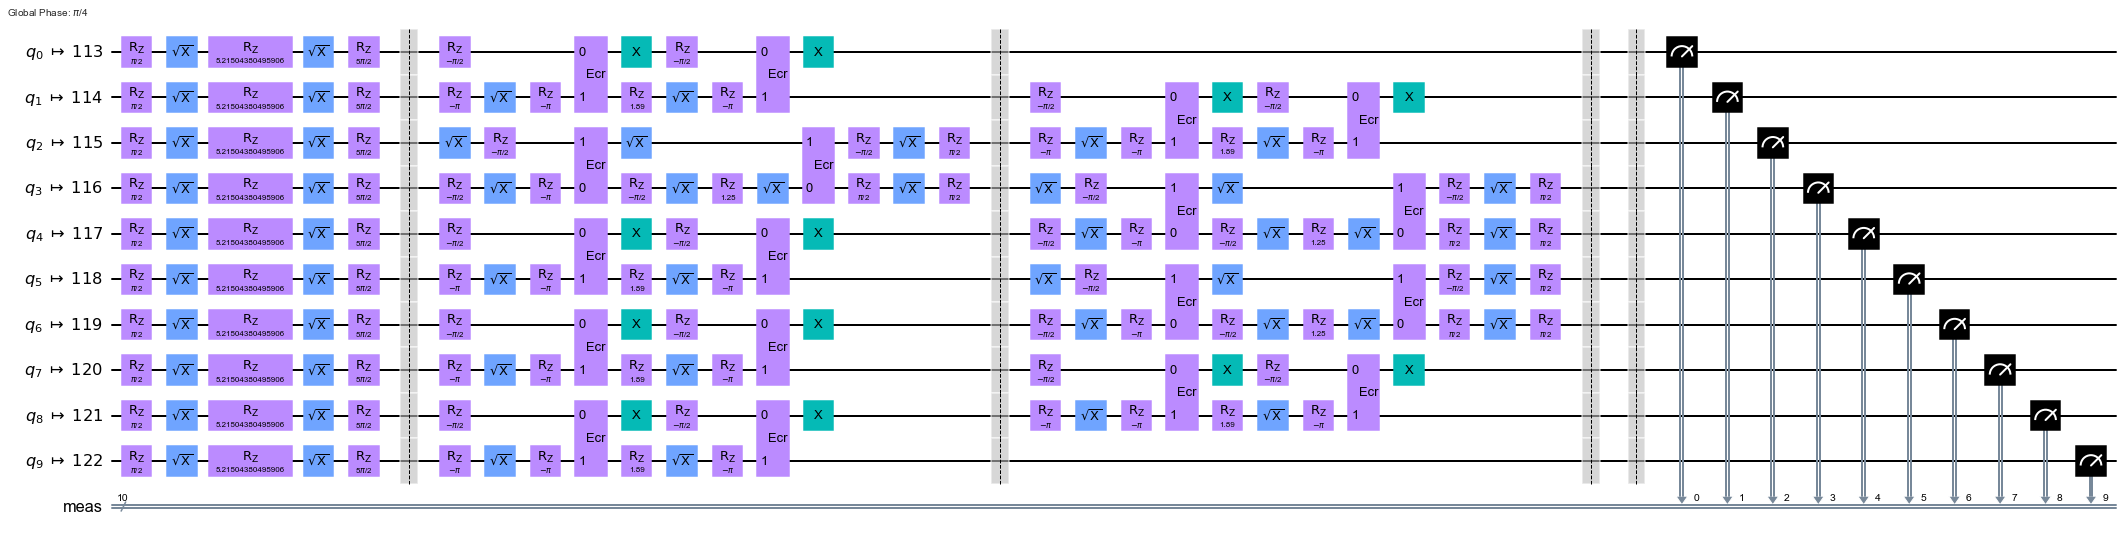

In [43]:
train_circuits[2].draw(**D)

In [47]:
from qiskit.result import marginal_counts
ideal_vals = []
for circ in tqdm(train_circuits[:120]+train_circuits[150:]):
# for circ in tqdm(train_circuits):
    counts_ideal = AerSimulator().run(circ, shots=100000).result().get_counts()
    ideal_exp_vals = -1*cal_z_exp(marginal_counts(counts_ideal, [0, 2, 4, 6, 9]))
    ideal_vals.append(ideal_exp_vals.tolist())

  0%|          | 0/270 [00:00<?, ?it/s]

In [48]:
to_df = []
# steps = np.repeat(np.arange(1, 11), 30)
steps = np.repeat([1, 2, 3, 4, 6, 7, 8, 9, 10], 30)

for i, (ideal_exp_val, noisy_exp_val, zne_mitigated, step, J) in tqdm(enumerate(zip(ideal_vals, noisy_vals, mitigated_vals, steps, Js)), total=len(ideal_vals)):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val
    row['zne_mitigated'] = zne_mitigated
    row['step'] = step
    row['J'] = J

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/270 [00:00<?, ?it/s]

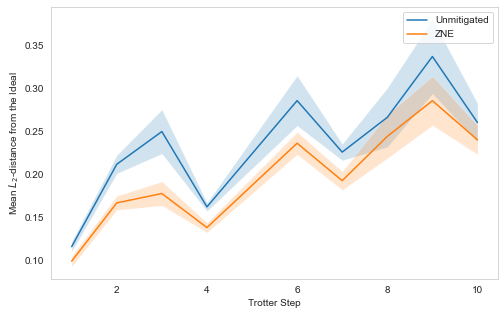

In [49]:
df = pd.DataFrame(to_df)
new_df = df
# new_df = df.iloc[[i for range_start in range(0, len(df), 60) for i in range(range_start+30, range_start+60)]]
# new_df = df.iloc[[i for range_start in range(30, len(df), 60) for i in range(range_start, range_start+30)]]


import warnings
warnings.filterwarnings('ignore')

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

# def l1_dist(list1, list2):
#     return np.sum([np.abs(a - b) for a, b in zip(list1, list2)])

for col in new_df.columns:
    if col not in ['step', 'ideal', 'J']:
        new_df[f'L2_{col}'] = new_df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

new_df_mean = new_df.groupby('step').agg('mean')
new_df_ste = new_df.groupby('step').agg('std') / np.sqrt(30)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
steps = sorted(set(new_df.step))
legend_labels = ['Unmitigated', 'ZNE']
for i, col in enumerate(['L2_noisy', 'L2_zne_mitigated']):
    plt.plot(steps, new_df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=new_df_mean[col]-new_df_ste[col], y2=new_df_mean[col]+new_df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
# plt.ylim([0, 0.64])
# plt.xlim([0, 29])
# plt.vlines(x=14, ymin=0, ymax=1, color='gray', label='Train data availability')
plt.legend()
plt.grid(None)
plt.show()

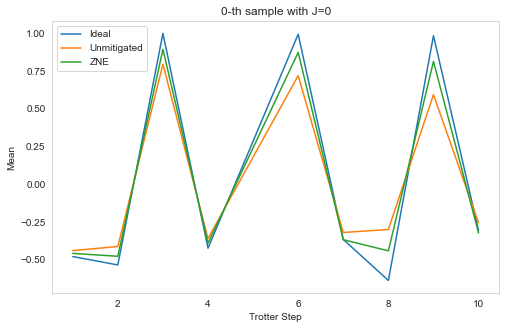

In [50]:
k = 0
new_df = pd.DataFrame(to_df).iloc[k::30]

import warnings
warnings.filterwarnings('ignore')

for col in new_df.columns:
    if col not in ['step']:
        new_df[f'mean_{col}'] = new_df[col].apply(np.mean)

new_df_mean = new_df.groupby('step').agg('mean')
new_df_ste = new_df.groupby('step').agg('std') / np.sqrt(len(new_df[new_df['step']==2]))

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
steps = sorted(set(new_df.step))
legend_labels = ['Ideal', 'Unmitigated', 'ZNE']
for i, col in enumerate(['mean_ideal', 'mean_noisy', 'mean_zne_mitigated']):
    plt.plot(steps, new_df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=new_df_mean[col]-new_df_ste[col], y2=new_df_mean[col]+new_df_ste[col], alpha=0.2)
plt.title(f'{k}-th sample with J={Js[k]}')
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean')
# plt.ylim([0, 0.64])
# plt.xlim([0, 29])
# plt.vlines(x=14, ymin=0, ymax=1, color='gray', label='Train data availability')
plt.legend()
plt.grid(None)
plt.show()

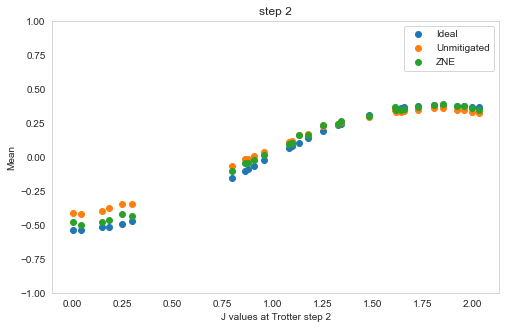

In [64]:
new_df = pd.DataFrame(to_df)
s =
new_df = new_df[new_df.step==s]

import warnings
warnings.filterwarnings('ignore')

for col in new_df.columns:
    if col not in ['step', 'J']:
        new_df[f'mean_{col}'] = new_df[col].apply(np.mean)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
samples = list(range(len(set(new_df.index))))
legend_labels = ['Ideal', 'Unmitigated', 'ZNE']
for i, col in enumerate(['mean_ideal', 'mean_noisy', 'mean_zne_mitigated']):
    plt.scatter(new_df.J, new_df[col], label=legend_labels[i])
plt.ylim([-1, 1])
plt.xlabel(f'J values at Trotter step {s}')
plt.ylabel(r'Mean')
plt.title(f'step {s}')
plt.legend()
plt.grid(None)
plt.show()

Text(0.5, 1.0, 'seed42; np.random.uniform(0, np.pi*0.66, 30), np.zeros(30)')

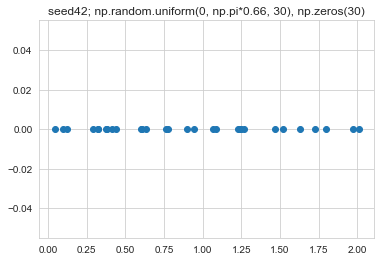

In [67]:
np.random.seed(42)
plt.scatter(np.random.uniform(0, np.pi*0.66, 30), np.zeros(30))
plt.title('seed42; np.random.uniform(0, np.pi*0.66, 30), np.zeros(30)')

Text(0.5, 1.0, 'seed0; np.random.uniform(0, np.pi*0.66, 30), np.zeros(30)')

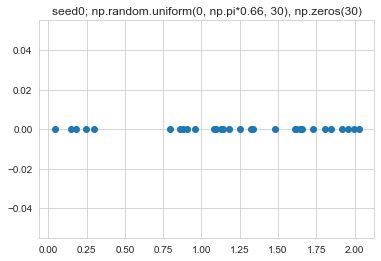

In [66]:
np.random.seed(0)
plt.scatter(np.random.uniform(0, np.pi*0.66, 30), np.zeros(30))
plt.title('seed0; np.random.uniform(0, np.pi*0.66, 30), np.zeros(30)')